In [ ]:
!pip install transformers
!pip install sentencepiece 

In [ ]:
import numpy as np
import pandas as pd
import os
import gc
import random
import regex as re
import logging
from tqdm import tqdm, trange
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import torch
import torch.nn as nn
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import XLMRobertaTokenizer
from transformers.models.xlm_roberta.modeling_xlm_roberta import  XLMRobertaModel, XLMRobertaConfig
from transformers import BertConfig, BertTokenizer, BertModel
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [ ]:
df_train = pd.read_excel('train.xlsx')
df_train

,source,targets,category
0,"When news is brought to one of them, of (the b...",و چون یکی از آنان را به [ولادت] دختر مژده دهند...,quran
1,After them repaired Zadok the son of Immer ove...,و چون دشمنان ما شنیدند که ما آگاه شده‌ایم و خد...,bible
2,And establish regular prayers at the two ends ...,و نماز را در دو طرف روز و ساعات نخستین شب برپا...,quran
3,"And it came to pass, that, when I was come aga...",و فرمود تا مدعیانش نزد تو حاضر شوند؛ و از او ب...,bible
4,"Ah woe, that Day, to the Rejecters of Truth!",وای در آن روز بر تکذیب کنندگان!,quran
...,...,...,...
12595,"Women impure are for men impure, and men impur...",زنان پلید برای مردان پلید و مردان پلید برای زن...,quran
12596,I don't want any silly dance given in my honour.',بنابراین حالا هم میل ندارم جشنی به افتخار من د...,mizan
12597,And the Earth will shine with the Glory of its...,و زمین به نور پروردگارش روشن می‌شود، و کتاب [ا...,quran
12598,"Then lifted I up mine eyes, and saw, and behol...",گفتم: «این چیست؟» او جواب داد: «این است آن ایف...,bible


{'bible': 0.3333333333333333,
 'mizan': 0.3333333333333333,
 'quran': 0.33325396825396825}

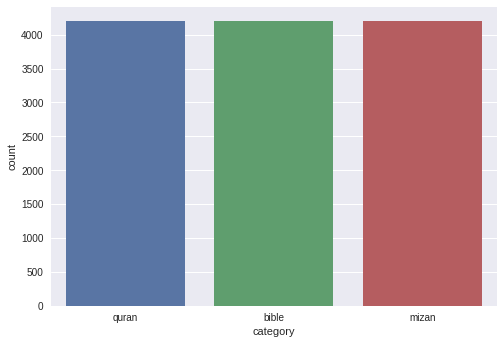

In [ ]:
freq_dict = dict()
for i in range(1, len(df_train)):
    data = df_train.iloc[i]
    if (data['category'] in freq_dict): freq_dict[data['category']] += 1
    else: freq_dict[data['category']] = 1

for k,v in freq_dict.items():
    freq_dict[k] = v / len(df_train)

sns.countplot(x=df_train['category'])
freq_dict

In [ ]:
df_valid = pd.read_excel('valid.xlsx')
df_valid

,source,targets,category
0,"And there came out a fire from the LORD, and c...",تا برای بنی‌اسرائیل یادگارباشد تا هیچ غریبی که...,bible
1,And out of them shall proceed thanksgiving and...,ویهودا و تمامی شهرهایش با هم و فلاحان و آنانی ...,bible
2,So We sent against them a furious Wind through...,سرانجام تندبادی سخت و سرد در روزهایی شوم بر آن...,quran
3,"""And drink Boiling Water on top of it:",و روی آن از آب جوشان خواهید نوشید،,quran
4,"I was starting to get sleepythough, according ...",داشت خوابم می‌گرفت اگرچه، به گفته‌ی ادوارد نصف...,mizan
...,...,...,...
2695,"And he left the oxen, and ran after Elijah, an...",و اینک نبی‌ای نزد اخاب، پادشاه اسرائیل آمده، گ...,bible
2696,Then which of the favours of your Lord will ye...,پس کدامیک از نعمت‌های پروردگارتان را انکار می‌...,quran
2697,"That was the deal, the price.",آن قرار و عهد ما بود. بهای آن.,mizan
2698,And when we burned incense to the queen of hea...,کلامی که خداوند درباره آمدن نبوکدرصرپادشاه باب...,bible


{'bible': 0.33296296296296296,
 'mizan': 0.3333333333333333,
 'quran': 0.3333333333333333}

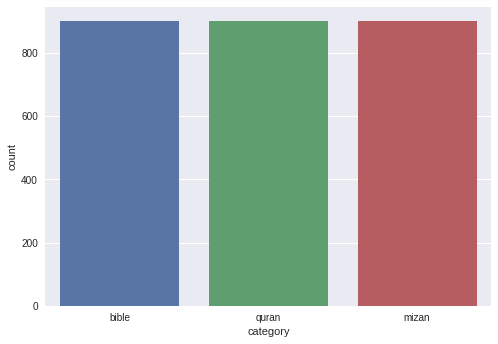

In [ ]:
freq_dict = dict()
for i in range(1, len(df_valid)):
    data = df_valid.iloc[i]
    if (data['category'] in freq_dict): freq_dict[data['category']] += 1
    else: freq_dict[data['category']] = 1

for k,v in freq_dict.items():
    freq_dict[k] = v / len(df_valid)

sns.countplot(x=df_valid['category'])
freq_dict

In [ ]:
df_test = pd.read_excel('test.xlsx')
df_test

,source,targets,category
0,The report will cost you five hundred pounds.,اینکار برای شما ۵۰۰لیره خرج برمی دارد.,mizan
1,"And the cart came into the field of Joshua, a ...",و سموئیل تمامی خاندان اسرائیل را خطاب کرده، گف...,bible
2,"Wherefore thus saith the Holy One of Israel, B...",‌ای بنی‌اسرائیل بسوی آن کس که بر وی بینهایت عص...,bible
3,"For when for the time ye ought to be teachers,...",و این مثلی است برای زمان حاضر که بحسب آن هدایا...,bible
4,Waited for her to turn,منتظر شدم تا بچرخد,mizan
...,...,...,...
2695,And the Spirit of God came upon Saul when he h...,وحال اینک پادشاه پیش روی شما راه می‌رود و من پ...,bible
2696,"If We had made it an angel, We should have sen...",[این مغالطه گران لجوج می‌گویند: چرا پیامبر از ...,quran
2697,"And the Wicked - they will be in the Fire,",و مسلما گناهکاران در دوزخ اند,quran
2698,What was wrong with him then?,مشکلش چیست؟,mizan


{'bible': 0.3333333333333333,
 'mizan': 0.33296296296296296,
 'quran': 0.3333333333333333}

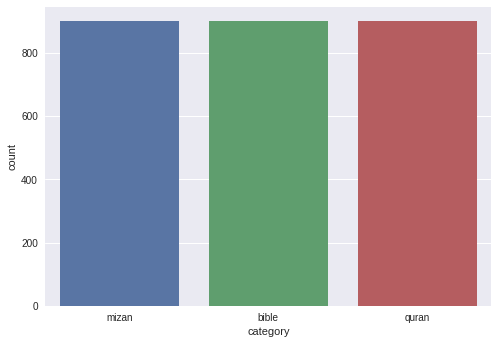

In [ ]:
freq_dict = dict()
for i in range(1, len(df_test)):
    data = df_test.iloc[i]
    if (data['category'] in freq_dict): freq_dict[data['category']] += 1
    else: freq_dict[data['category']] = 1

for k,v in freq_dict.items():
    freq_dict[k] = v / len(df_test)

sns.countplot(x=df_test['category'])
freq_dict

In [ ]:
class Classifier(nn.Module):
    def __init__(self, input_dim, num_labels=3, dropout_rate=0.):
        super(Classifier, self).__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.linear1 = nn.Linear(input_dim, input_dim // 3)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(input_dim // 3, num_labels)

    def forward(self, x):
        x = self.dropout(x)
        x = self.linear1(x)
        x = self.relu(x)
        return self.linear2(x)

In [ ]:
class BERT(BertModel):
    def __init__(self, config, args, label_lst):
        super(BERT, self).__init__(config)
        self.args = args
        self.num_labels = len(set(label_lst))
        self.bert = BertModel(config=config) # Load pretrained Bert
        self.classifier = Classifier(config.hidden_size, self.num_labels, args.dropout_rate)

    def forward(self, input_ids, attention_mask, token_type_ids, label_ids):
        outputs = self.bert(input_ids, attention_mask, token_type_ids)  # sequence_output, pooled_output, (hidden_states), (attentions)
        pooled_output = outputs[1]  # [CLS]
        label_logits = self.classifier(pooled_output)

        total_loss = 0
        # Softmax
        if label_ids is not None:
            loss = 0
            if self.num_labels == 1:
                loss_fct = nn.MSELoss()
                loss = loss_fct(label_logits.view(-1), label_ids.view(-1))
            else:
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(label_logits.view(-1, self.num_labels), label_ids.view(-1))
            total_loss += loss

        outputs = (label_logits,) + outputs[2:]  # add hidden states and attention if they are here
        outputs = (total_loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

In [ ]:
class PARSBERT(BertModel):
    def __init__(self, config, args, label_lst):
        super(PARSBERT, self).__init__(config)
        self.args = args
        self.num_labels = len(set(label_lst))
        self.bert = BertModel(config=config) # Load pretrained Bert
        self.classifier = Classifier(config.hidden_size, self.num_labels, args.dropout_rate)

    def forward(self, input_ids, attention_mask, token_type_ids, label_ids):
        outputs = self.bert(input_ids, attention_mask, token_type_ids)  # sequence_output, pooled_output, (hidden_states), (attentions)
        pooled_output = outputs[1]  # [CLS]
        label_logits = self.classifier(pooled_output)

        total_loss = 0
        # Softmax
        if label_ids is not None:
            loss = 0
            if self.num_labels == 1:
                loss_fct = nn.MSELoss()
                loss = loss_fct(label_logits.view(-1), label_ids.view(-1))
            else:
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(label_logits.view(-1, self.num_labels), label_ids.view(-1))
            total_loss += loss

        outputs = (label_logits,) + outputs[2:]  # add hidden states and attention if they are here
        outputs = (total_loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

In [ ]:
class XLMRoBERTa(BertModel):
    def __init__(self, config, args, label_lst):
        super(XLMRoBERTa, self).__init__(config)
        self.args = args
        self.num_labels = len(set(label_lst))
        self.roberta = XLMRobertaModel(config=config) # Load pretrained RoBerta
        self.classifier = Classifier(config.hidden_size, self.num_labels, args.dropout_rate)

    def forward(self, input_ids, attention_mask, token_type_ids, label_ids):
        outputs = self.roberta(input_ids, attention_mask, token_type_ids)  # sequence_output, pooled_output, (hidden_states), (attentions)
        pooled_output = outputs[1]  # [CLS]
        label_logits = self.classifier(pooled_output)

        total_loss = 0
        # Softmax
        if label_ids is not None:
            loss = 0
            if self.num_labels == 1:
                loss_fct = nn.MSELoss()
                loss = loss_fct(label_logits.view(-1), label_ids.view(-1))
            else:
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(label_logits.view(-1, self.num_labels), label_ids.view(-1))
            total_loss += loss

        outputs = (label_logits,) + outputs[2:]  # add hidden states and attention if they are here
        outputs = (total_loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

In [ ]:
MODEL_CLASSES = {
    'XLMRoberta': (XLMRobertaConfig, XLMRoBERTa, XLMRobertaTokenizer),
    'parsbert': (BertConfig, PARSBERT, BertTokenizer),
    'bert': (BertConfig, BERT, BertTokenizer),
}

MODEL_PATH_MAP = {
    'XLMRoberta': 'xlm-roberta-base',
    'bert': 'bert-base-uncased',
    'parsbert': 'HooshvareLab/bert-fa-zwnj-base',
}

logger = logging.getLogger(__name__)

In [ ]:
def load_tokenizer(args):
    return MODEL_CLASSES[args.model_type][2].from_pretrained(args.model_name_or_path)

def init_logger():
    logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                        datefmt='%m/%d/%Y %H:%M:%S',
                        level=logging.INFO)
    
def label2index(label):
    if (label == 'quran'): return 0
    elif (label == 'bible'): return 1
    else: return 2

def get_labels(dataset):
  train_label = list()
  for i in range(len(dataset)):
      data = dataset.iloc[i]
      train_label.append(data['category'])
  
  return train_label

def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if not args.no_cuda and torch.cuda.is_available():
        torch.cuda.manual_seed_all(args.seed)

In [ ]:
def prepare_dataset(data, col, args, tokenizer, padding='max_length'):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_label = torch.tensor(data['category'].apply(label2index), dtype=torch.long).to(device)
    if (len(col) > 1):
        bert_input = tokenizer(list(data[col[0]]), list(data[col[1]]), padding=padding, max_length=args.max_seq_len, truncation=True, return_tensors="pt")
        dataset = TensorDataset(bert_input['input_ids'].to(device), bert_input['attention_mask'].to(device), torch.zeros_like(bert_input['input_ids']).to(device), all_label)
    else:
        bert_input = tokenizer(list(data[col[0]]), padding=padding, max_length=args.max_seq_len, truncation=True, return_tensors="pt")
        dataset = TensorDataset(bert_input['input_ids'].to(device), bert_input['attention_mask'].to(device), bert_input['token_type_ids'].to(device), all_label)
     
    return dataset

In [ ]:
class Trainer(object):
    def __init__(self, args, train_dataset=None, dev_dataset=None, test_dataset=None):
        self.args = args
        self.train_dataset = train_dataset
        self.dev_dataset = dev_dataset
        self.test_dataset = test_dataset

        self.label_lst = get_labels(df_train)

        self.config_class, self.model_class, _ = MODEL_CLASSES[args.model_type]
        self.config = self.config_class.from_pretrained(args.model_name_or_path, finetuning_task=args.task)
        self.model = self.model_class.from_pretrained(args.model_name_or_path,
                                                      config=self.config,
                                                      args=args,
                                                      label_lst=self.label_lst)
                                                      

        # GPU or CPU
        self.device = "cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu"
        self.model.to(self.device)

    def train(self):
        train_sampler = RandomSampler(self.train_dataset)
        train_dataloader = DataLoader(self.train_dataset, sampler=train_sampler, batch_size=self.args.train_batch_size)
        if self.args.max_steps > 0:
            t_total = self.args.max_steps
            self.args.num_train_epochs = self.args.max_steps // (len(train_dataloader) // self.args.gradient_accumulation_steps) + 1
        else:
            t_total = len(train_dataloader) // self.args.gradient_accumulation_steps * self.args.num_train_epochs

        # Prepare optimizer and schedule (linear warmup and decay)
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'weight_decay': self.args.weight_decay},
            {'params': [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.args.learning_rate, eps=self.args.adam_epsilon)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=self.args.warmup_steps, num_training_steps=t_total)

        # Train!
        logger.info("***** Running training *****")
        logger.info("  Num examples = %d", len(self.train_dataset))
        logger.info("  Num Epochs = %d", self.args.num_train_epochs)
        logger.info("  Total train batch size = %d", self.args.train_batch_size)
        logger.info("  Gradient Accumulation steps = %d", self.args.gradient_accumulation_steps)
        logger.info("  Total optimization steps = %d", t_total)
        logger.info("  Logging steps = %d", self.args.logging_steps)
        logger.info("  Save steps = %d", self.args.save_steps)

        global_step = 0
        tr_loss = 0.0
        self.model.zero_grad()
        best_acc = -1
       
        train_iterator = trange(int(self.args.num_train_epochs), desc="Epoch")
        for _ in train_iterator:
            label_preds = None
            out_label_ids = None
            for step, batch in enumerate(train_dataloader):
                self.model.train()
                inputs = {'input_ids': batch[0],
                          'attention_mask': batch[1],
                          'token_type_ids': batch[2],
                          'label_ids': batch[3]}
                outputs = self.model(**inputs)
                loss = outputs[0]
                label_logits = outputs[1]

                 # label prediction
                if label_preds is None:
                    label_preds = label_logits.detach().cpu().numpy()
                    out_label_ids = inputs['label_ids'].detach().cpu().numpy()
                else:
                    label_preds = np.append(label_preds, label_logits.detach().cpu().numpy(), axis=0)
                    out_label_ids = np.append(out_label_ids, inputs['label_ids'].detach().cpu().numpy(), axis=0)
                
                if self.args.gradient_accumulation_steps > 1:
                    loss = loss / self.args.gradient_accumulation_steps

                loss.backward()

                tr_loss += loss.item()
                if (step + 1) % self.args.gradient_accumulation_steps == 0:
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.args.max_grad_norm)

                    optimizer.step()
                    scheduler.step()  # Update learning rate schedule
                    self.model.zero_grad()
                    global_step += 1

                    if(global_step % 50 == 0): logger.info("Train loss = %.4f", tr_loss / global_step)
                    if (self.args.logging_steps > 0 and global_step % self.args.logging_steps == 0):
                        results = self.evaluate("dev")
                        if (float(results['accuracy']) > best_acc):
                          best_acc = float(results['accuracy'])
                          logger.info("valid best_acc = %.4f", best_acc * 100.0)
                          self.save_model()

                
            if 0 < self.args.max_steps < global_step:
                train_iterator.close()
                break
            
            # label result
            label_preds = np.argmax(label_preds, axis=1)
            logger.info("train_acc = %.4f", accuracy_score(out_label_ids, label_preds) * 100.0)



        return global_step, tr_loss / global_step

    def evaluate(self, mode):
        if mode == 'test':
            dataset = self.test_dataset
        elif mode == 'dev':
            dataset = self.dev_dataset
        else:
            raise Exception("Only dev and test dataset available")

        eval_sampler = SequentialSampler(dataset)
        eval_dataloader = DataLoader(dataset, sampler=eval_sampler, batch_size=self.args.eval_batch_size)

        # Eval!
        logger.info("\n***** Running evaluation on %s dataset *****", mode)
        logger.info("  Num examples = %d", len(dataset))
        logger.info("  Batch size = %d", self.args.eval_batch_size)
        eval_loss = 0.0
        nb_eval_steps = 0
        label_preds = None
        out_label_ids = None

        self.model.eval()

        # for batch in tqdm(eval_dataloader, desc="Evaluating"):
        for batch in eval_dataloader:
            batch = tuple(t.to(self.device) for t in batch)
            with torch.no_grad():
                inputs = {'input_ids': batch[0],
                          'attention_mask': batch[1],
                          'token_type_ids': batch[2],
                          'label_ids': batch[3]}
                outputs = self.model(**inputs)
                tmp_eval_loss, label_logits = outputs[:2]
                eval_loss += tmp_eval_loss.mean().item()
            
            nb_eval_steps += 1

            # label prediction
            if label_preds is None:
                label_preds = label_logits.detach().cpu().numpy()
                out_label_ids = inputs['label_ids'].detach().cpu().numpy()
            else:
                label_preds = np.append(label_preds, label_logits.detach().cpu().numpy(), axis=0)
                out_label_ids = np.append(out_label_ids, inputs['label_ids'].detach().cpu().numpy(), axis=0)


        eval_loss = eval_loss / nb_eval_steps
        results = {
            "loss": eval_loss
        }

        # label result
        m = nn.Softmax(dim = 1)
        temp_preds = m(torch.Tensor(label_preds))
        label_preds = np.argmax(label_preds, axis=1)
        total_result = accuracy_score(out_label_ids, label_preds)
        results.update({'accuracy' : total_result})
        logger.info("***** Eval results *****")
        for key in sorted(results.keys()):
            logger.info("  %s = %.4f", key if key != 'loss' else 'loss', float(results[key]) * 100.0 if key != 'loss' else float(results[key]))

        if (mode == 'test'): 
            print(classification_report(out_label_ids, label_preds, target_names=['quran', 'bible', 'mizan'], digits = 4))
            print(('AUC = %.4f') % (roc_auc_score(out_label_ids, temp_preds, average = 'macro', multi_class = 'ovr')))

        return results

    def save_model(self):
        # Save model checkpoint (Overwrite)
        if not os.path.exists(self.args.model_dir):
            os.makedirs(self.args.model_dir)
        model_to_save = self.model.module if hasattr(self.model, 'module') else self.model
        model_to_save.save_pretrained(self.args.model_dir)


    def load_model(self):
        # Check whether model exists
        if not os.path.exists(self.args.model_dir):
            raise Exception("Model doesn't exists! Train first!")

        try:
            self.model = self.model_class.from_pretrained(self.args.model_dir,
                                                          args=self.args,
                                                          label_lst=self.label_lst)
            self.model.to(self.device)
            logger.info("***** Model Loaded *****")
        except:
            raise Exception("Some model files might be missing...")


In [ ]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

English using BERT

In [ ]:
args = dotdict(dict())
args.seed = 810197502 # to make results reproducible
args.model_type = 'bert' 
args.model_name_or_path = MODEL_PATH_MAP[args.model_type]
args.dropout_rate =  0.2
args.do_train = True
args.do_eval = True
args.train_batch_size = 32 
args.max_steps = -1
args.task = 'Classification' 
args.no_cuda = False
args.weight_decay = 0
args.num_train_epochs = 10
args.gradient_accumulation_steps = 1 
args.learning_rate = 3e-5 
args.adam_epsilon = 1e-8
args.warmup_steps = 0 
args.logging_steps = 500
args.save_steps = 500
args.max_grad_norm = 1
args.eval_batch_size = 32
args.model_dir = "Model_" + args.model_type
args.max_seq_len = 128

In [ ]:
# english with bert

init_logger()
set_seed(args)
tokenizer = load_tokenizer(args)

In [ ]:
col = ['source']
train_dataset = prepare_dataset(df_train, col, args, tokenizer)
valid_dataset = prepare_dataset(df_valid, col, args, tokenizer)
test_dataset = prepare_dataset(df_test, col, args, tokenizer)

In [ ]:
trainer = Trainer(args, train_dataset, valid_dataset, test_dataset)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BERT: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BERT from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BERT from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BERT were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['encoder.layer.1.attention.self.query.bias', 'encoder

In [ ]:
gc.collect()
torch.cuda.empty_cache()

if args.do_train:
    # trainer.load_model()
    trainer.train()

if args.do_eval:
    # trainer.load_model()
    trainer.evaluate("test")

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
05/25/2022 06:26:41 - INFO - __main__ -   ***** Running training *****
05/25/2022 06:26:41 - INFO - __main__ -     Num examples = 12600
05/25/2022 06:26:41 - INFO - __main__ -     Num Epochs = 10
05/25/2022 06:26:41 - INFO - __main__ -     Total train batch size = 32
05/25/2022 06:26:41 - INFO - __main__ -     Gradient Accumulation steps = 1
05/25/2022 06:26:41 - INFO - __main__ -     Total optimization steps = 3940
05/25/2022 06:26:41 - INFO - __main__ -     Logging steps = 500
05/25/2022 06:26:41 - INFO - __main__ -     Save steps = 500
Epoch:   0%|          | 0/10 [00:00<?, ?it/s]05/25/2022 06:27:12 - INFO - __main__ -   Train loss = 0.7819
05/25/2022 06:27:44 - INFO - __main__ - 

              precision    recall  f1-score   support

       quran     0.9854    0.9744    0.9799       900
       bible     0.9813    0.9900    0.9856       900
       mizan     0.9834    0.9856    0.9845       900

    accuracy                         0.9833      2700
   macro avg     0.9833    0.9833    0.9833      2700
weighted avg     0.9833    0.9833    0.9833      2700

AUC = 0.9980


Persian Using PARSBERT

In [ ]:
# persian with parsbert
args.model_type = 'parsbert' 
args.model_name_or_path = MODEL_PATH_MAP[args.model_type]
args.model_dir = "Model_" + args.model_type

init_logger()
set_seed(args)
tokenizer = load_tokenizer(args)

Downloading:   0%|          | 0.00/416k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/292 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/565 [00:00<?, ?B/s]

In [ ]:
col = ['targets']
train_dataset = prepare_dataset(df_train, col, args, tokenizer)
valid_dataset = prepare_dataset(df_valid, col, args, tokenizer)
test_dataset = prepare_dataset(df_test, col, args, tokenizer)

In [ ]:
trainer = Trainer(args, train_dataset, valid_dataset, test_dataset)

Downloading:   0%|          | 0.00/452M [00:00<?, ?B/s]

Some weights of the model checkpoint at HooshvareLab/bert-fa-zwnj-base were not used when initializing PARSBERT: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing PARSBERT from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing PARSBERT from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of PARSBERT were not initialized from the model checkpoint at HooshvareLab/bert-fa-zwnj-base and are newly initialized: ['encoder.layer.3.attention.output.Layer

In [ ]:
gc.collect()
torch.cuda.empty_cache()

if args.do_train:
    # trainer.load_model()
    trainer.train()

if args.do_eval:
    # trainer.load_model()
    trainer.evaluate("test")

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
05/25/2022 07:44:17 - INFO - __main__ -   ***** Running training *****
05/25/2022 07:44:17 - INFO - __main__ -     Num examples = 12600
05/25/2022 07:44:17 - INFO - __main__ -     Num Epochs = 10
05/25/2022 07:44:17 - INFO - __main__ -     Total train batch size = 32
05/25/2022 07:44:17 - INFO - __main__ -     Gradient Accumulation steps = 1
05/25/2022 07:44:17 - INFO - __main__ -     Total optimization steps = 3940
05/25/2022 07:44:17 - INFO - __main__ -     Logging steps = 500
05/25/2022 07:44:17 - INFO - __main__ -     Save steps = 500
Epoch:   0%|          | 0/10 [00:00<?, ?it/s]05/25/2022 07:44:49 - INFO - __main__ -   Train loss = 0.7539
05/25/2022 07:45:23 - INFO - __main__ - 

              precision    recall  f1-score   support

       quran     0.9680    0.9733    0.9706       900
       bible     0.9775    0.9644    0.9709       900
       mizan     0.9592    0.9667    0.9629       900

    accuracy                         0.9681      2700
   macro avg     0.9682    0.9681    0.9682      2700
weighted avg     0.9682    0.9681    0.9682      2700

AUC = 0.9963


Multilingual with XLM-RoBERTa

In [ ]:
# multilingual with XLMRoberta
args.model_type = 'XLMRoberta' 
args.model_name_or_path = MODEL_PATH_MAP[args.model_type]
args.model_dir = "Model_" + args.model_type

init_logger()
set_seed(args)
tokenizer = load_tokenizer(args)

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [ ]:
col = ['source', 'targets']
train_dataset = prepare_dataset(df_train, col, args, tokenizer)
valid_dataset = prepare_dataset(df_valid, col, args, tokenizer)
test_dataset = prepare_dataset(df_test, col, args, tokenizer)

In [ ]:
trainer = Trainer(args, train_dataset, valid_dataset, test_dataset)

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRoBERTa: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRoBERTa from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRoBERTa from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRoBERTa were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['encoder.layer.3.attention.output.LayerNorm.bias', 'encoder.layer.1.attention.self.key.bias', 'pooler.dense.bias', 'encoder.layer.1.attention.output.LayerNorm.weight', 'encoder.

In [ ]:
gc.collect()
torch.cuda.empty_cache()

if args.do_train:
    # trainer.load_model()
    trainer.train()

if args.do_eval:
    # trainer.load_model()
    trainer.evaluate("test")

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
05/25/2022 08:33:05 - INFO - __main__ -   ***** Running training *****
05/25/2022 08:33:05 - INFO - __main__ -     Num examples = 12600
05/25/2022 08:33:05 - INFO - __main__ -     Num Epochs = 10
05/25/2022 08:33:05 - INFO - __main__ -     Total train batch size = 32
05/25/2022 08:33:05 - INFO - __main__ -     Gradient Accumulation steps = 1
05/25/2022 08:33:05 - INFO - __main__ -     Total optimization steps = 3940
05/25/2022 08:33:05 - INFO - __main__ -     Logging steps = 500
05/25/2022 08:33:05 - INFO - __main__ -     Save steps = 500
Epoch:   0%|          | 0/10 [00:00<?, ?it/s]05/25/2022 08:33:44 - INFO - __main__ -   Train loss = 0.9824
05/25/2022 08:34:22 - INFO - __main__ - 

              precision    recall  f1-score   support

       quran     0.9911    0.9933    0.9922       900
       bible     0.9934    0.9978    0.9956       900
       mizan     0.9955    0.9889    0.9922       900

    accuracy                         0.9933      2700
   macro avg     0.9933    0.9933    0.9933      2700
weighted avg     0.9933    0.9933    0.9933      2700

AUC = 0.9997
